# Semantic Segmentation

### Import frameworks, libraries and modules

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy import io
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [2]:
# Use tf.test.is_built_with_cuda() to validate if TensorFlow was built with CUDA support.
tf.test.is_built_with_cuda()

True

# Download and prepare data

### Download masks

In [3]:
# ## OS ####
path_mask_folder = os.path.pardir+os.sep+'lib'+os.sep+'MASKS'
path_mask_folder

'..\\lib\\MASKS'

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# path_mask_folder = '/content/drive/MyDrive/Diploma/MASKS'

In [6]:
mask_path = []

for root, dirs, files in os.walk(path_mask_folder):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)
len(mask_path)

1004

### Download images

In [7]:
### OS ###
path_images_folder = os.path.pardir+os.sep+'lib'+os.sep+'IMAGES'
path_images_folder

'..\\lib\\IMAGES'

In [8]:
# path_images_folder = '/content/drive/MyDrive/Diploma/IMAGES'

In [9]:
image_path_ = []

for root, dirs, files in os.walk(path_images_folder):
    for file in files:
        path = os.path.join(root,file)
        image_path_.append(path)
len(image_path_)

2097

### Sorting the masks to match the image

In [10]:
mask_path.sort()

In [11]:
image_path_.sort()

### Separating the training set associated with the masks

In [12]:
image_path = image_path_[:len(mask_path)]

In [13]:
len(image_path)

1004

### Reading masks and images

In [14]:
images = []

for path in image_path:
    file = tf.io.read_file(path)
    image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
    images.append(image)

masks = []

for path in mask_path:
    file = tf.io.read_file(path)
    mask = tf.image.decode_png(file, channels=1, dtype=tf.uint8)
    masks.append(mask)

### Sample few images and visualize

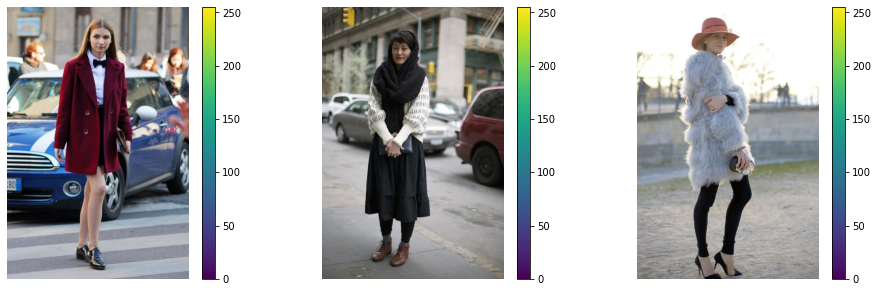

In [15]:
plt.figure(figsize=(16,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[60+i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')
plt.show()

Изображения ярлыков имеют 59 сегментированных классов, 
соответствующих таким классам, как волосы, сумка, рубашка, обувь, кожа, 
солнцезащитные очки и кепка.

### Sample corresponding masks and visualize

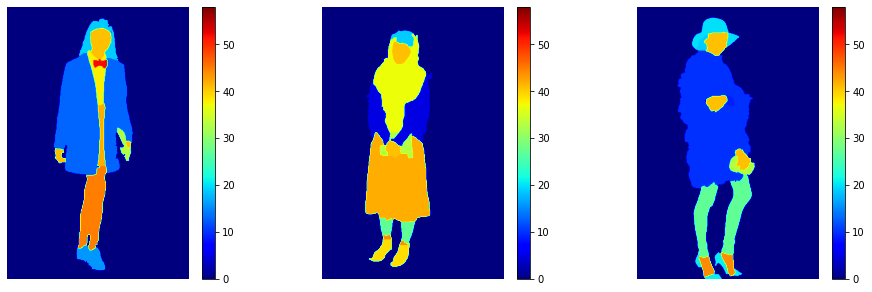

In [16]:
norm = mpl.colors.Normalize(vmin=0, vmax=58)

plt.figure(figsize=(16,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[60+i]
    plt.imshow(tf.squeeze(img), cmap='jet', norm=norm)
    plt.colorbar()
    plt.axis('off')
plt.show()

### Download masks label

In [17]:
### OS ####
path_pixel_level = os.path.pardir+os.sep+'lib'+os.sep+'clothing-co-parsing' \
                                                        +os.sep+'annotations'+os.sep+'pixel-level'
path_pixel_level

'..\\lib\\clothing-co-parsing\\annotations\\pixel-level'

In [18]:
# label_list = pd.read_csv('/content/drive/MyDrive/Diploma/labels.csv')
# label_list.head()

In [19]:
pixel_level_of_images = []

for root, dirs, files in os.walk(path_pixel_level):
    pixel_level_of_images.append(len(files))
    
segmentations = []

for i in range(1,pixel_level_of_images[0]+1):
    
    url = path_pixel_level+os.sep+ '%04d.mat'%(i)
    
    # Чтение файлов .ma
    file = io.loadmat(url)
    mask = tf.convert_to_tensor(file['groundtruth'])
    # resize ожидает 3D-изображения, но мы получили 2D-изображение в оттенках серого
    mask = tf.expand_dims(mask,-1)
    mask = tf.image.resize_with_crop_or_pad(mask,825,550)
    segmentations.append(mask)
    
list_unique_mask = np.unique(tf.squeeze(segmentations))

if min(list_unique_mask)==0:
    num_mask = max(list_unique_mask)+1

In [25]:
# num_mask = label_list.shape[0]
# num_mask

# Data Preprocessing

In [33]:
images[0].shape, masks[0].shape

(TensorShape([825, 550, 3]), TensorShape([825, 550, 1]))

### Resize data as the model expects. 

In [38]:
def resize_image(image):
    # scale the image
    image = tf.cast(image, tf.float32)
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image

def resize_mask(mask):
    # resize the mask
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask    

In [39]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]
len(X), len(y)

(1004, 1004)

In [40]:
images[0].dtype, masks[0].dtype, X[0].dtype, y[0].dtype

(tf.uint8, tf.uint8, tf.float32, tf.uint8)

### Visualize a resized image and a resized mask

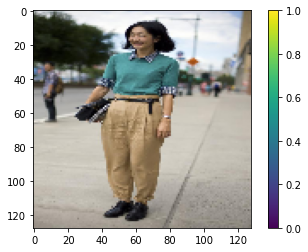

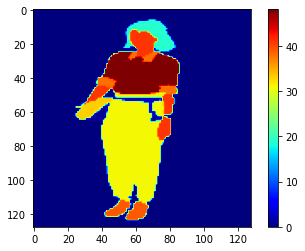

In [41]:
# plot an image
plt.imshow(X[57])
plt.colorbar()
plt.show()

#plot a mask
plt.imshow(tf.squeeze(y[57]), cmap='jet')
plt.colorbar()
plt.show()

# Split Data for training and validation

Разделим данные на набор для обучения и проверки в соотношении 80/20.  
Обвернем данные в  объекты TensorFlow Dataset для обучающих и проверочных наборов, чтобы упростить дальнейшую обработку данных.

In [42]:
from sklearn.model_selection import train_test_split
# split data into 80/20 ratio
train_X, val_X,train_y, val_y = train_test_split(X, y, test_size=0.2, 
                                                      random_state=0
                                                     )
# С помощью tf.data.Dataset.from_tensor_slices() метода мы можем получить срезы массива
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

# verify the shapes and data types
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

# Data Augmentation 

У нас меньше данных (всего 800 примеров в обучающей выборке), которых недостаточно для глубокого обучения. Следовательно, мы должны увеличить объем обучающих данных, выполняя приращения данных. Определим функции для увеличения данных.

In [43]:
def brightness(img, mask):
    # adjust brightness of image
    # don't alter in mask
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    # adjust gamma of image
    # don't alter in mask
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    # adjust hue of image
    # don't alter in mask
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    # crop both image and mask identically
    img = tf.image.central_crop(img, 0.7)
    # resize after cropping
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    # resize afer cropping
    mask = tf.image.resize(mask, (128,128))
    # cast to integers as they are class numbers
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    # flip both image and mask identically
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    # flip both image and mask identically
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    # rotate both image and mask identically
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

Объединим исходный обучающий набор с расширенным новым набором. Не выполняйте увеличение данных с набором проверки.   
У нас есть 7 функций и 800 примеров ввода. 7 * 800 = 5600 новых примеров.  
Включая оригинальные примеры, получаем 5600 + 800 = 6400 примеров для обучения.  

In [44]:
# zip images and masks
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

# perform augmentation on train data only

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

# concatenate every new augmented sets
train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

## Efficient training

In [45]:
BATCH = 64

BUFFER = 6400

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

#### cache

Кэширует элементы в этом наборе данных.  

При первом повторении набора данных его элементы будут кэшироваться либо в указанном файле, либо в памяти.  
Последующие итерации будут использовать кешированные данные.  

#### shuffle

Случайным образом перемешивает элементы этого набора данных.  

Этот набор данных заполняет буфер `buffer_size` элементами, а затем произвольно  
выбирает элементы из этого буфера, заменяя выбранные элементы новыми элементами.   
Для идеального перемешивания требуется размер буфера больше или равный полному размеру набора данных.  

`reshuffle_each_iterati` onопределяет, должен ли порядок воспроизведения быть разным для каждой эпохи.  

#### batch

Объединяет последовательные элементы этого набора данных в пакеты.  

#### prefetch

Создает объект, Datasetкоторый предварительно выбирает элементы из этого набора данных.  
Если используется значение `tf.data.AUTOTUNE` размер буфера настраивается динамически.

In [46]:
train = train.cache()
train = train.shuffle(buffer_size = BUFFER, reshuffle_each_iteration=True)
train = train.batch(batch_size = BATCH)
train = train.repeat()
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)

val = val.batch(batch_size = BATCH)

# Build U-Net model

In [31]:
def unet(num_classes = None, input_shape=None):
    img_input = Input(input_shape)
    # Block 1
    x = Conv2D(64, (3, 3), padding='same' , name='block1_conv1')(img_input)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    block_1_out = Activation('relu')(x)
    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    block_2_out = Activation('relu')(x)
    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    block_3_out = Activation('relu')(x)
    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    block_4_out = Activation('relu')(x)
    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv1')(x)
    x = Activation('relu')(x)
    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv2')(x)
    x = Activation('relu')(x)
    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv3')(x)
    block_5_out = Activation('relu')(x)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP1')(block_5_out)
    x = Activation('relu')(x)
    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(x)
    x = Activation('relu')(x)
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
    x = Activation('relu')(x)
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    
    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
    x = Activation('relu')(x)
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(num_classes, (3, 3), activation='tanh', padding='same')(x)

    model = Model(img_input, x)

    model.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
    # model.summary()
    return model

In [32]:
Unet = unet(num_classes = num_mask, input_shape = (128, 128, 3))

# Training and Fine-tuning

In [50]:
hist_1 = Unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=50,
               verbose=2)

Epoch 1/50
12/12 - 334s - loss: 2.8814 - accuracy: 0.7323 - val_loss: 2.6880 - val_accuracy: 0.7647 - 334s/epoch - 28s/step
Epoch 2/50
12/12 - 333s - loss: 2.6981 - accuracy: 0.7466 - val_loss: 2.6509 - val_accuracy: 0.7647 - 333s/epoch - 28s/step
Epoch 3/50
12/12 - 339s - loss: 2.7015 - accuracy: 0.7394 - val_loss: 2.6509 - val_accuracy: 0.7647 - 339s/epoch - 28s/step
Epoch 4/50
12/12 - 359s - loss: 2.7034 - accuracy: 0.7385 - val_loss: 2.6509 - val_accuracy: 0.7647 - 359s/epoch - 30s/step
Epoch 5/50
12/12 - 345s - loss: 2.6911 - accuracy: 0.7446 - val_loss: 2.6509 - val_accuracy: 0.7647 - 345s/epoch - 29s/step
Epoch 6/50
12/12 - 352s - loss: 2.6947 - accuracy: 0.7429 - val_loss: 2.6509 - val_accuracy: 0.7647 - 352s/epoch - 29s/step
Epoch 7/50
12/12 - 356s - loss: 2.6997 - accuracy: 0.7403 - val_loss: 2.6509 - val_accuracy: 0.7647 - 356s/epoch - 30s/step
Epoch 8/50
12/12 - 371s - loss: 2.7032 - accuracy: 0.7386 - val_loss: 2.6509 - val_accuracy: 0.7647 - 371s/epoch - 31s/step
Epoch 9/

KeyboardInterrupt: 

### Make some prediction and visualize them to evaluate the model qualitatively.

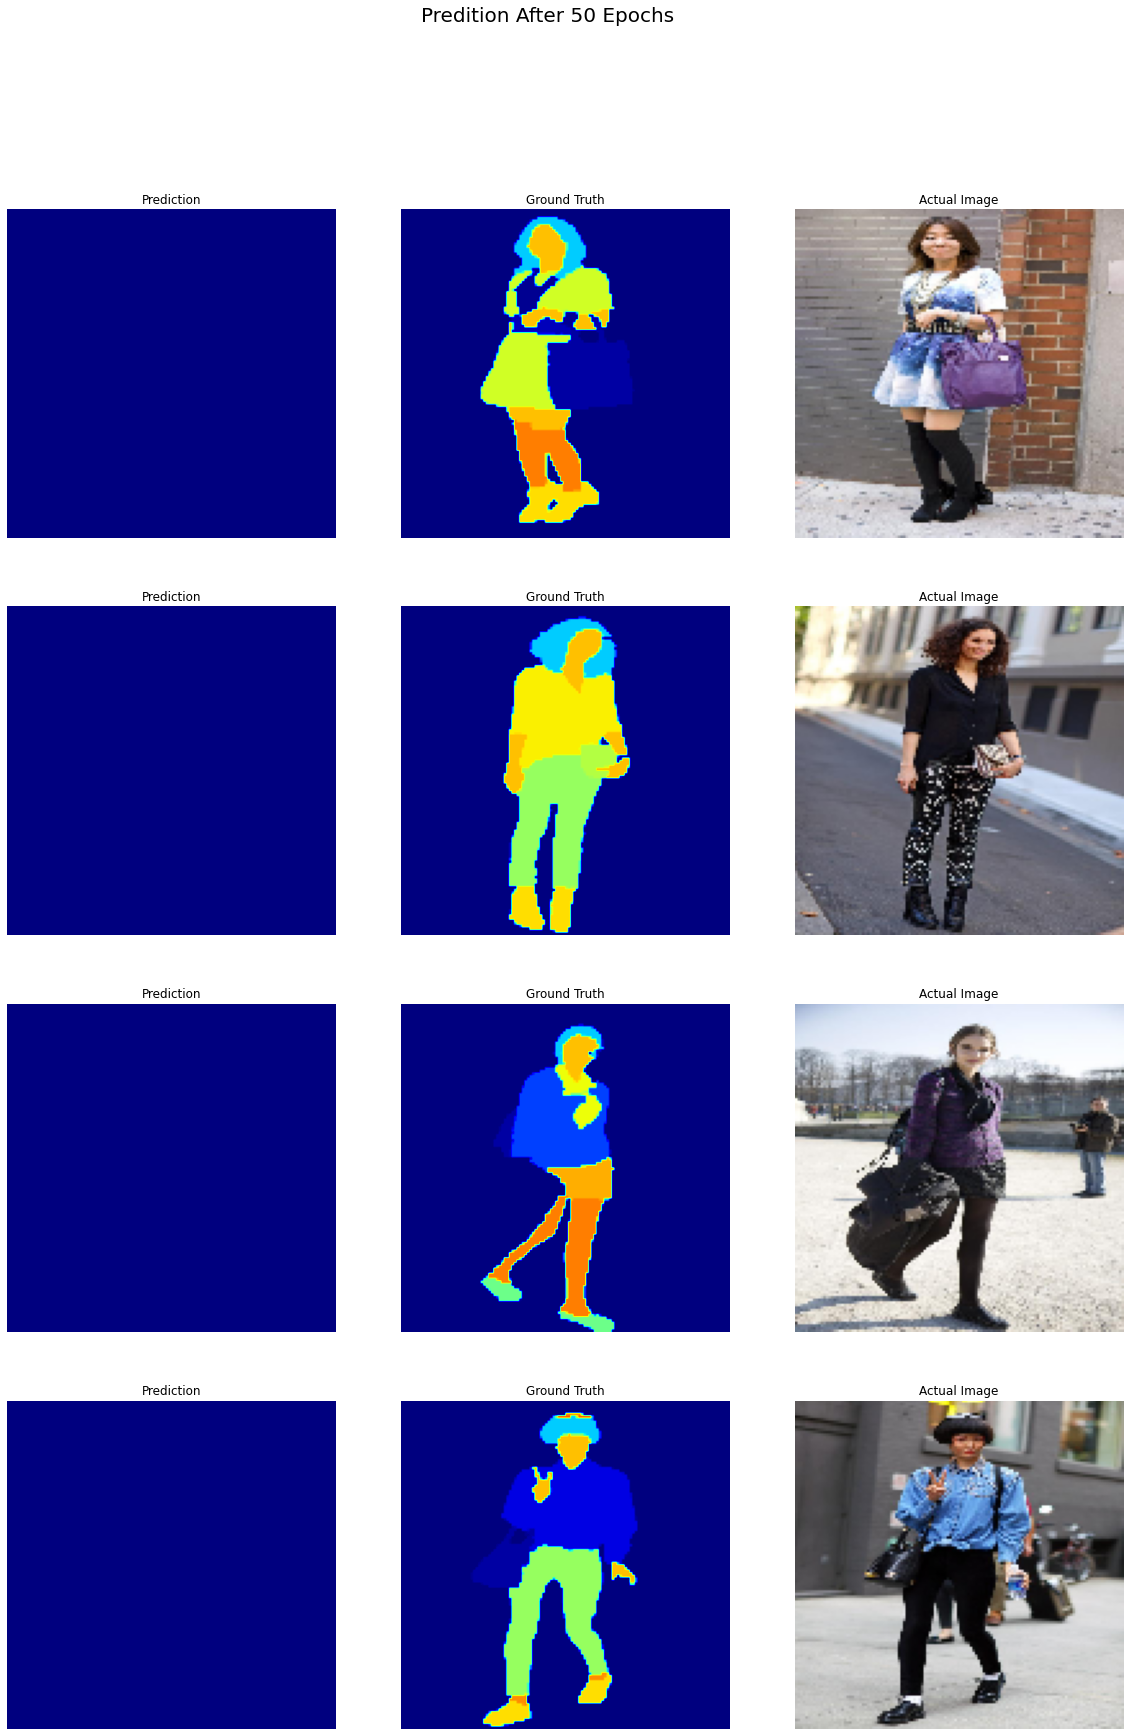

In [54]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = Unet.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=norm)
    plt.axis('off')
    plt.title('Prediction')
    
    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(tf.squeeze(mask[k]), cmap='jet', norm=norm)
    plt.axis('off')
    plt.title('Ground Truth')
    
    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 50 Epochs', size=20)  
plt.show()

# Performance Curves

### Plot the performance curves to understand how the model learnt on the data 

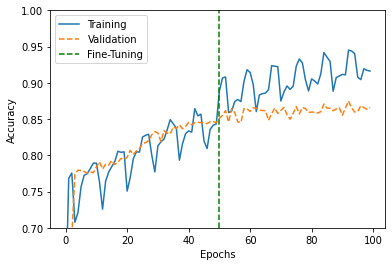

In [ ]:
# history_1 = hist_1.history
# acc=history_1['accuracy']
# val_acc = history_1['val_accuracy']

# history_2 = hist_2.history
# acc.extend(history_2['accuracy'])
# val_acc.extend(history_2['val_accuracy'])

# plt.plot(acc[:150], '-', label='Training')
# plt.plot(val_acc[:150], '--', label='Validation')
# plt.plot([50,50],[0.7,1.0], '--g', label='Fine-Tuning')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.ylim([0.7,1.0])
# plt.legend()
# plt.show()

# Saving model

In [ ]:
# Unet.save_weights(path_weights)